In [3]:
from math import sin,cos,tan,exp
import matplotlib.pyplot as plt
from scipy.stats import norm,uniform
import numpy as np
from scipy.linalg import inv, pinv, pinv2
import seaborn as sns
import scipy

In [1]:
from sklearn.model_selection import train_test_split

Create the data to fit to

In [4]:
np.random.seed(10)
noise = 1.5 *norm.rvs(size = 10)

In [6]:
def yfunc(x):
    return 10 * sin(2 * x)

X = uniform.rvs(0,10,1000)
t = np.array([yfunc(pt) + 2* norm.rvs() for pt in X])

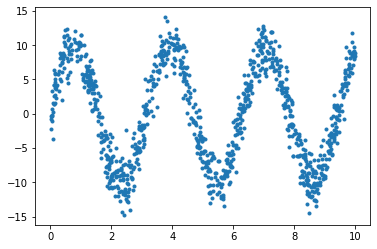

In [9]:
plt.plot(X,t,'.')

In [10]:
X_train, X_test, t_train, t_test = train_test_split(
...     X, t, test_size=0.25, random_state=42)

Create a kernel function. Let's start with a Gaussian Kernel.

In [41]:
def k(x1,x2,sigma = 1):
    return exp((-abs(x1-x2)**2) / (2 * sigma **2))
    

(0, 1)

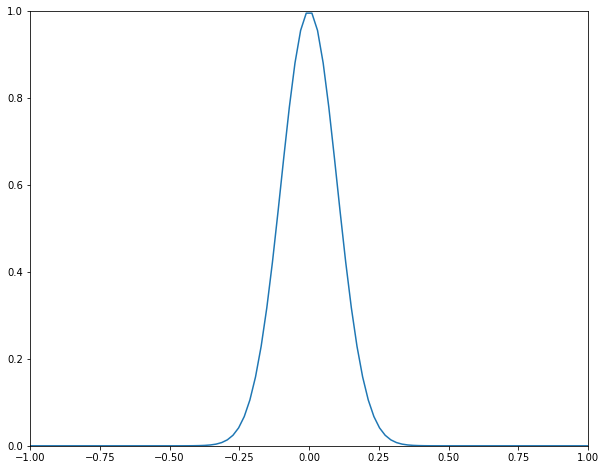

In [44]:
x1_test = np.linspace(-1,1,100)
out = [k(x1,0,.1) for x1 in x1_test]

fig,ax = plt.subplots(figsize = (10,8))
ax.plot(x1_test,out)
ax.set_xlim([-1,1])
ax.set_ylim([0,1])

Construct the K matrix

In [51]:
K = np.zeros(shape = (len(X_train),len(X_train)))

for i in range(len(X_train)):
    for j in range(len(X_train)):
        K[i,j] = k(X_train[i],X_train[j],sigma = .05)

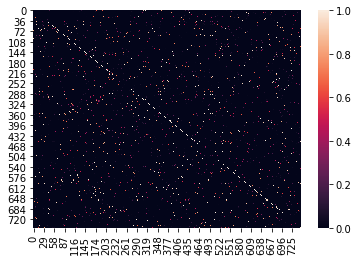

In [52]:
sns.heatmap(K)

Check the conditioning of the K matrix

In [53]:
np.linalg.cond(K)`

4.647560035265767e+19

The conditioning stinks.  I am not going to get a good inverse of K as is. I'm going to add a small amount to the diagonal terms to try and improve the conditioning.

In [73]:
K2 = K + np.eye(K.shape[0])*.001
np.linalg.cond(K2)

16073.33832880177

In [74]:
np.linalg.inv(np.linalg.inv(K2))

array([[ 1.00100000e+00, -1.38932221e-38, -2.81383647e-42, ...,
        -1.88545698e-24,  4.06601223e-48,  2.78237275e-43],
       [-1.65332691e-43,  1.00100000e+00, -2.26544964e-15, ...,
        -1.73093537e-29, -1.32342750e-21, -9.76266108e-16],
       [-5.88832510e-48,  7.14365160e-17,  1.00100000e+00, ...,
        -1.65794327e-33,  1.27476293e-16,  5.56112838e-15],
       ...,
       [-2.36081857e-27,  1.94287327e-26,  7.12644970e-30, ...,
         1.00100000e+00, -1.03957904e-33,  5.20768343e-29],
       [ 3.11765090e-55, -5.87735671e-28,  2.12566498e-25, ...,
         2.91768001e-41,  1.00100000e+00,  5.23295246e-20],
       [-5.36238164e-49,  7.89893123e-22, -7.86406166e-16, ...,
        -9.00822328e-35,  1.00465135e-15,  1.00100000e+00]])

That looks better

---

Now run the fit

Calculate the inverse of the Grahm Matrix

In [91]:
_lambda = 5
temp = K2 + _lambda * np.eye(K2.shape[0])
Kinv = np.linalg.inv(temp)

In [93]:
np.linalg.cond(temp)

4.2138249007718205

In [92]:
np.linalg.inv(Kinv)

array([[ 6.00100000e+000,  6.10547169e-091,  4.07347111e-104, ...,
         2.74403152e-053,  1.23034280e-130,  3.08864521e-112],
       [-2.29519031e-091,  6.00100000e+000,  2.06106447e-029, ...,
         1.18767993e-053,  8.80129558e-055,  1.27656100e-037],
       [-2.15309346e-104, -7.95685296e-030,  6.00100000e+000, ...,
        -7.48981842e-068,  7.28679105e-041,  3.05703782e-024],
       ...,
       [-1.75146805e-053, -3.09576214e-055, -1.67127058e-066, ...,
         6.00100000e+000, -1.05701918e-091,  1.58235193e-074],
       [-1.15434635e-129, -1.82430791e-054, -5.24226115e-041, ...,
         2.71974603e-092,  6.00100000e+000, -1.87971148e-033],
       [ 8.75838989e-113, -4.05346201e-037,  1.20995327e-023, ...,
        -1.88185470e-074, -3.33953811e-033,  6.00100000e+000]])

In [94]:
def pred(xp,_lambda = 10):
    prod1 = np.array([k(xn,xp,.1) for xn in X_train]).reshape((-1,1))
    prod2 = Kinv
    prod3 = t_train.reshape((-1,1))
    
    term1 = np.matmul(prod1.T,prod2)
    
    return np.matmul(term1,prod3)[0][0]
    #return [prod1,prod2,prod3]
    

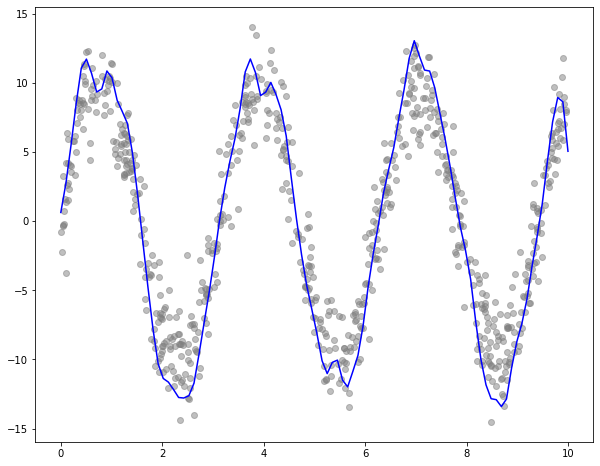

In [99]:
fig,ax = plt.subplots(figsize = (10,8))
ax.scatter(X_train,t_train,color = 'grey',alpha = .5)
tempx = np.linspace(0,10,100)
t_predict = [pred(x) for x in tempx]
ax.plot(tempx,t_predict,color ='blue')


In [123]:
xp=0
_lambda = 0

prod1 = np.array([k(xn,xp) for xn in x]).reshape(-1,1)
prod2 =np.linalg.inv(K + _lambda * np.identity(K.shape[0]))

In [106]:
K
Kinv = np.linalg.inv(K)
myident = np.eye(100)
test = np.matmul(K,Kinv)